# This script is meant to help complement Chapter 2 of the Barto-Sutton RL textbook. Feel free to experiment with parameters and visualize how rewards change!


In [23]:
import torch
import numpy as np
from matplotlib import pyplot as plt
#Example Set of parameters
# stationary = True
# num_steps = 1000"
# num_runs = 2000
# k = 10
# epsilon = 0.1
# Q_init_value = 5
# UCB = True
# c = 2
empty_tensor = torch.empty(0)

In [5]:
#Define function that will allow for exploration vs exploitation based on epsilon
import random
def decision(probability):
    return random.random() < probability

In [166]:
#define a k-armed bandit with multiple parameters 
# stationary vs non stationary (mean, stddev)
# Define how Q_a is updated (sample average vs constant step size (alpha))
# Define the initial value of Q_a (higher --> more exploration)
# UCB action selection setting (bool True or False), with param c to determine the degree of exploration
# num_steps is the number of steps before termination, and num_runs is the number of different k-armed bandits over which to average results

def bandit(stationary, num_steps, num_runs, k=10, epsilon=0.05, Q_init_value=0, std_dev = 0.01, act_val_method = 'Sample-average', alpha = 0.1, UCB = False, c = 2):
    reward_runs_list = []
    optimal_runs_list = []
    for j in range(num_runs):
        Q_a = empty_tensor.new_full([k], Q_init_value)
        rewards = torch.normal(torch.zeros(k), torch.ones(k))
        N_a = torch.zeros(k)
        reward_val = []
        opt_val = []
        max_action_val = torch.argmax(rewards).item()
        assert act_val_method in ['Sample-average', 'Constant-step-size', None]
        print ("Run: {0} Reward List: {1}".format(j, rewards))
        for i in range(num_steps):
            if not stationary:
                rewards += torch.normal(torch.zeros(k), empty_tensor.new_full([k], std_dev))
            if UCB:
                quotient = torch.sqrt(torch.from_numpy(np.array((np.log(j+1))/((N_a+1).numpy()))))
                max_action = torch.argmax(Q_a + (c * quotient))
                non_changed = (Q_a==Q_init_value).nonzero()
                if len(non_changed)>1:
                    max_action = np.random.choice((Q_a==Q_init_value).nonzero().squeeze().numpy())
            elif decision(epsilon)==False:
                max_action = torch.argmax(Q_a).item()
                non_changed = (Q_a==Q_init_value).nonzero()
                if len(non_changed)>1:
                    max_action = np.random.choice((Q_a==Q_init_value).nonzero().squeeze().numpy())
            else:
                max_action = np.random.randint(0, k)
            reward = torch.normal(rewards[max_action], 1)
            times_seen = N_a[max_action] 
            estimate = Q_a[max_action]
            N_a[max_action] += 1
            if (act_val_method == 'Constant-step-size'):
                step_param = alpha
            else:
                step_param = (1/(times_seen+1))
            Q_a[max_action] += (reward - estimate)*(step_param)
            reward_val.append(reward.item())
            opt_val.append(max_action == max_action_val)
            print ("Step {0}: Action chosen:{1}   Reward:{2:.2f}    Estimate: {3:.2f}".format(i, max_action, reward.item(), estimate))
        reward_runs_list.append(reward_val)
        optimal_runs_list.append(opt_val)
    reward_runs_array = np.array(reward_runs_list)
    avg_reward_per_step = np.mean(reward_runs_array, axis=0)
    opt_arr = np.array(optimal_runs_list, dtype="bool")
    percent_opt_arr = np.sum(opt_arr, axis=0)/num_runs
    return (avg_reward_per_step, percent_opt_arr)


In [167]:
avg_reward_per_step, percent_opt_arr = bandit(stationary=False, num_steps=1000, num_runs=100, Q_init_value=5, UCB=True, act_val_method = 'Constant-step-size')



Run: 0 Reward List: tensor([ 1.8840, -1.2257, -0.4741,  0.4187,  1.3108, -2.9199, -0.5343,  0.9041,
         1.1772, -0.9500])
Step 0: Action chosen:5   Reward:-3.16    Estimate: 4.18
Step 1: Action chosen:2   Reward:-2.15    Estimate: 4.29
Step 2: Action chosen:8   Reward:1.44    Estimate: 4.64
Step 3: Action chosen:7   Reward:2.32    Estimate: 4.73
Step 4: Action chosen:3   Reward:0.51    Estimate: 4.55
Step 5: Action chosen:4   Reward:2.90    Estimate: 4.79
Step 6: Action chosen:0   Reward:2.38    Estimate: 4.74
Step 7: Action chosen:9   Reward:0.55    Estimate: 4.55
Step 8: Action chosen:1   Reward:-1.05    Estimate: 4.39
Step 9: Action chosen:6   Reward:1.13    Estimate: 4.61
Step 10: Action chosen:4   Reward:0.99    Estimate: 4.41
Step 11: Action chosen:0   Reward:1.57    Estimate: 4.42
Step 12: Action chosen:7   Reward:1.85    Estimate: 4.44
Step 13: Action chosen:8   Reward:0.46    Estimate: 4.23
Step 14: Action chosen:6   Reward:-1.74    Estimate: 3.98
Step 15: Action chosen:9

Text(0.5, 1.0, 'Average Reward per Step')

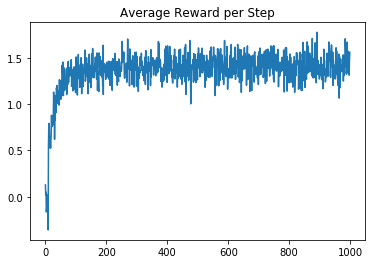

In [97]:
#Plotting Average reward over step
plt.plot(avg_reward_per_step)
plt.title('Average Reward per Step')

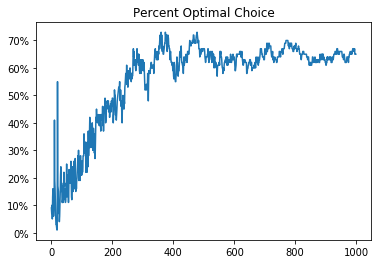

In [169]:
#Plotting Percent Optimal Choice
import matplotlib.ticker as mtick
fig, ax = plt.subplots()
ax.plot(percent_opt_arr*100)
plt.title('Percent Optimal Choice')
fmt = '%.f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
plt.show()
